In [1]:
import numpy as np
import sacc
import matplotlib.pyplot as plt
import pyccl as ccl
import scipy
import importlib as imp
import astropy.io.fits as fits
from more_itertools import locate

import CM_code.spurious_george as sp
imp.reload(sp)
import CM_code.halo_model as halo
imp.reload(halo)
import CM_code.lsst_coZmology as zed
imp.reload(zed)
import CM_code.tjp_helper as tjp_helper
imp.reload(tjp_helper)

# import main.py from TJPCov folder
import tjpcov as tjp
from tjpcov.covariance_calculator import CovarianceCalculator

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

### load in data from Danielle

In [2]:
# redshift data
lensFile = '/home/b7009348/WGL_project/LSST-SRD-data/DL-validation-covs/dNdz_clust_LSSTSRD_Y1_zb0_sigz0.03.dat'
sourceFile = '/home/b7009348/WGL_project/LSST-SRD-data/DL-validation-covs/dNdz_srcs_LSSTSRD_Y1_zb0_sigz0.05.dat'

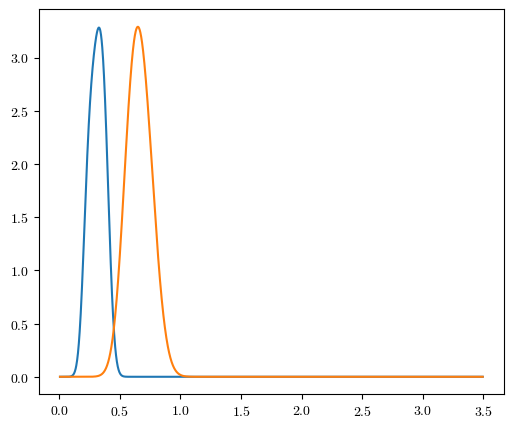

In [3]:
lensZ_data = np.loadtxt(lensFile)
sourceZ_data = np.loadtxt(sourceFile)

# get data for lens bin 1
z_lens = lensZ_data[:,0]
lens1 = lensZ_data[:,1]

# get data for source bin 3
z_src = sourceZ_data[:,0]
source3 = sourceZ_data[:,3]

plt.figure(figsize=[6,5])
plt.plot(z_lens, lens1)
plt.plot(z_src, source3)

In [4]:
# find fraction of lenses in bin 1
all_lenses = lensZ_data[:,1]+lensZ_data[:,2]+lensZ_data[:,3]+lensZ_data[:,4]+lensZ_data[:,5]
tot_area = scipy.integrate.simps(all_lenses, z_lens)
lens1_area = scipy.integrate.simps(lens1, z_lens)

lens1_frac = lens1_area/tot_area
print(lens1_frac)

# check all bins add to tot_area
test_area = 0.
for i in range(5):
    test_area = test_area + scipy.integrate.simps(lensZ_data[:,i+1], z_lens)
    
print(test_area)
print(tot_area)

0.17326885993147878
3.632241623126337
3.6322416231263372


In [5]:
# load in ell bin data
ellFile = '/home/b7009348/WGL_project/LSST-SRD-data/DL-validation-covs/ell-values.txt'
ell_bins = np.loadtxt(ellFile)
print(ell_bins)

[   23.5997     32.8594     45.75227    63.70386    88.69901   123.5014
   171.959     239.4297    333.3735    464.1775    646.3045    899.8917
  1252.978    1744.602    2429.122    3382.225    4709.291    6557.052
  9129.808   12712.02   ]


### Construct SACC file for TJP cov

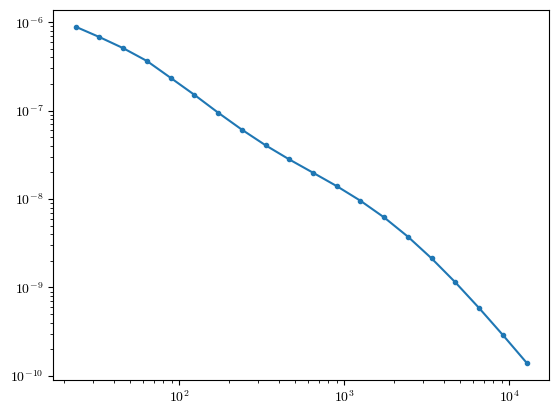

In [6]:
s = sacc.Sacc()

# construct IA model
f_red = 0.16
A_IA = 5.

IA_amps = f_red * A_IA * np.ones(len(z_lens))

# add redshift data tracers
s.add_tracer('NZ', 'lens', z=z_lens, nz=lens1)
s.add_tracer('NZ', 'source', z=z_src, nz=source3)

# construct Cl_gM for sacc file
lensTracer = ccl.NumberCountsTracer(zed.cosmo_SRD, has_rsd=False, dndz=(z_lens, lens1), 
                                    bias=(z_lens, 1.562362*np.ones_like(z_lens)))
shearTracer = ccl.WeakLensingTracer(zed.cosmo_SRD, (z_src, source3), has_shear=True,
                                   ia_bias=(z_src, IA_amps))

Cl = ccl.angular_cl(zed.cosmo_SRD, lensTracer, shearTracer, ell_bins)
plt.loglog(ell_bins,Cl,marker='.')

s.add_ell_cl('cl_0e', 'lens', 'source', ell_bins, Cl)

s.save_fits('generated_data/source3-lens1_fourier_data.fits', overwrite=True)

In [6]:
print(Cl.size, ell_bins.size)

NameError: name 'Cl' is not defined

In [6]:
# set configuration dictionary for TJPcov
config = tjp_helper.generate_config(cosmo=zed.cosmo_SRD, sacc_file='generated_data/source3-lens1_fourier_data.fits',
                                   cov_type='FourierGaussianFsky', Nlen=lens1_frac*18., Nsrc=0.2*10., 
                                    sig_e=0.26, len_bias=1.562362, IA=0.8,
                                   add_keys=[['GaussianFsky',['fsky', 18000/41253]]])

In [8]:
# initialise calculator object
CovCalc = CovarianceCalculator(config)

# get matrix 
l1_s3_cov = CovCalc.get_covariance()

Computing independent covariance blocks
('lens', 'source') ('lens', 'source')
Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')


In [9]:
desc_cov = np.loadtxt('/home/b7009348/WGL_project/LSST-SRD-data/LSST_DESC_SRD_v1_release/forecasting/WL-LSS-CL/cov/Y1_3x2pt_clusterN_clusterWL_cov')
print(np.shape(desc_cov))

indexes = list(locate(desc_cov[:,0], lambda x: 300 <= x <= 319))
desc_cov = desc_cov[indexes]

indexes = list(locate(desc_cov[:,1], lambda x: 300 <= x <= 319))
desc_cov = desc_cov[indexes]

ggl_gauss_13 = desc_cov[:,8]
ggl_gauss_13 = np.reshape(ggl_gauss_13, [20,20])

(265275, 10)


In [10]:
print(np.diag(l1_s3_cov))
print(np.diag(ggl_gauss_13))

[1.45865534e-14 4.51896557e-15 1.34128411e-15 3.76740933e-16
 9.22902128e-17 2.29817549e-17 5.85464850e-18 1.60031427e-18
 4.76021303e-19 1.53490266e-19 5.22853014e-20 1.81858012e-20
 6.23651552e-21 2.06608457e-21 6.55134857e-22 2.00536852e-22
 6.08977598e-23 1.91472501e-23 6.53592976e-24 2.49951502e-24]
[1.683097e-14 5.299148e-15 1.599951e-15 4.607306e-16 1.142944e-16
 2.815046e-17 7.106713e-18 1.948655e-18 5.829834e-19 1.887651e-19
 6.457747e-20 2.251882e-20 7.750442e-21 2.573631e-21 8.160558e-22
 2.484344e-22 7.434370e-23 2.275358e-23 7.475601e-24 2.741457e-24]


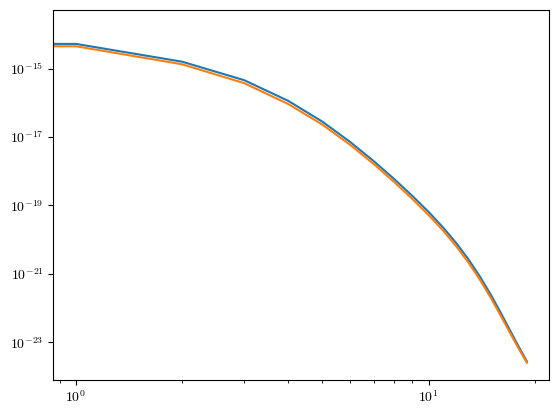

In [11]:
plt.loglog(np.diag(ggl_gauss_13))
plt.loglog(np.diag(l1_s3_cov))

(0.0, 1.0)

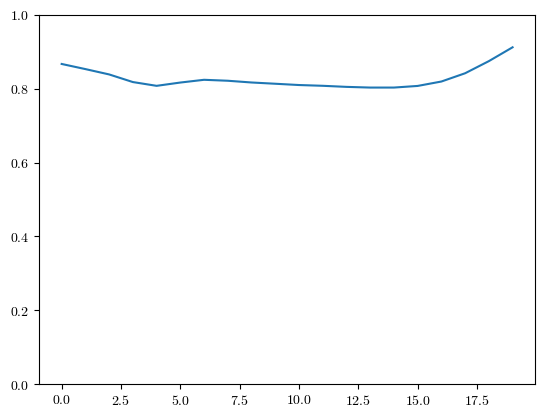

In [12]:
plt.plot(np.diag(l1_s3_cov)/np.diag(ggl_gauss_13))
plt.ylim([0,1])

In [ ]:
[1.48025905e-19 7.19569252e-21 2.28054114e-21 1.01262411e-21
 5.36084504e-22 3.18890148e-22 2.06556065e-22 1.42510676e-22
 1.03947994e-22 7.86536228e-23 6.19458355e-23 5.00928308e-23
 4.16198121e-23 3.51352991e-23 3.00794601e-23 2.64932281e-23
 2.32138406e-23 2.09340417e-23 1.87813093e-23 1.71859642e-23]

In [357]:
# load in SRD data vector to compare to own data
ggl_file = np.loadtxt('/home/b7009348/WGL_project/LSST-SRD-data/LSST_DESC_SRD_v1_release/forecasting/WL-LSS-CL/datav/3x2pt_clusterN_clusterWL_Y1_fid')

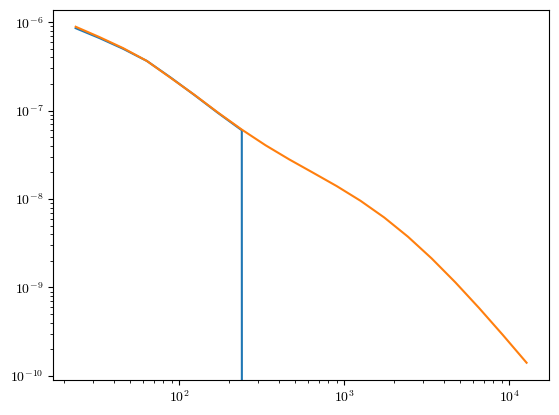

In [409]:
cl_0e = ggl_file[300:320,1]
plt.loglog(ell_bins, cl_0e)
plt.loglog(ell_bins,Cl)

In [38]:
dtype = s.get_data_types()[0]
tracers = s.get_tracer_combinations(data_type=dtype)[0]
ell_eff, _ = s.get_ell_cl(dtype, *tracers)

nbpw = ell_eff.size

ellb_min, ellb_max = ell_eff.min(), ell_eff.max()
# assuming constant log bins
del_logell = np.log10(ell_eff[1:] / ell_eff[:-1]).mean()
ell_min = 2 * ellb_min / (10**del_logell + 1)
ell_max = 2 * ellb_max / (1 + 10 ** (-del_logell))

ell_min = ell_min
ell_max = ell_max
ell_edges = np.logspace(
    np.log10(ell_min), np.log10(ell_max), nbpw + 1
)
ell = np.logspace(np.log10(ell_min * 0.98), np.log10(ell_max * 1.02), nbpw * 60)
# binned covariance can be sensitive to the th values. Make sure
# you check convergence for your application

In [34]:
print(ellb_min)
print(ell_min)
print(ell_edges)
print(ell_bins)

23.5997
19.729181197892213
[   19.7291812     27.4702188     38.24856761    53.25596185
    74.15173037   103.24626437   143.75647141   200.16146054
   278.69778587   388.04900622   540.30580387   752.30282005
  1047.48001779  1458.47437817  2030.7284871   2827.51500474
  3936.93256032  5481.64659021  7632.45213871 10627.15822537
 14796.88177463]
[   23.5997     32.8594     45.75227    63.70386    88.69901   123.5014
   171.959     239.4297    333.3735    464.1775    646.3045    899.8917
  1252.978    1744.602    2429.122    3382.225    4709.291    6557.052
  9129.808   12712.02   ]


2000


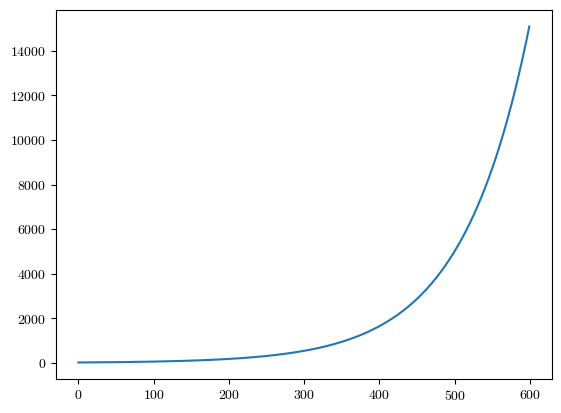

In [41]:
plt.plot(ell)
print(nbpw * 100)

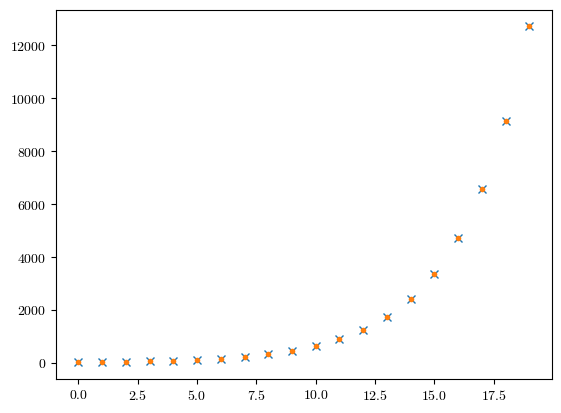

In [38]:
plt.plot(tjp_bins,lw=0.,marker='x')
plt.plot(ell_bins,lw=0.,marker='.')
#plt.plot(ell)

In [23]:
def bin_cov(r, r_bins):  # works for cov and skewness
    """Function to apply the binning operator.
    This function works on both one dimensional vectors and two dimensional
    covariance covrices.
    Args:
        r: theta or ell values at which the un-binned vector is computed.
        cov: Unbinned covariance. It also works for a vector of C_ell or xi
        r_bins: theta or ell bins to which the values should be binned.
    Returns:
        array_like: Binned covariance or vector of C_ell or xi
    """
    bin_center = 0.5 * (r_bins[1:] + r_bins[:-1])
    return bin_center

tjp_bins = bin_cov(ell,ell_edges)
print(tjp_bins.size)


print(ell_bins)
print(tjp_bins)

20
[   23.5997     32.8594     45.75227    63.70386    88.69901   123.5014
   171.959     239.4297    333.3735    464.1775    646.3045    899.8917
  1252.978    1744.602    2429.122    3382.225    4709.291    6557.052
  9129.808   12712.02   ]
[   23.5997        32.85939321    45.75226473    63.70384611
    88.69899737   123.50136789   171.95896597   239.4296232
   333.37339604   464.17740505   646.30431196   899.89141892
  1252.97719798  1744.60143263  2429.12174592  3382.22378253
  4709.28957526  6557.04936446  9129.80518204 12712.02      ]
